# Greedy query strategies

These strategies don't care what other samples have been picked. Just pick the top-K samples with the best score.

In [181]:
#imports
import numpy as np

# matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt

import tensorflow as tf
tf.get_logger().setLevel(tf.compat.v1.logging.ERROR)

from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.utils import MISSING_LABEL

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelBinarizer
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

# https://stackoverflow.com/questions/8391411/how-to-block-calls-to-print
import sys, os
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

## Uncertainty-based strategy

The first method is uncertainty-based. We will use a dropout turned on bayesian neural network as classifier. Given this clf we will compute.
$$
P(y|x) \approx \frac{1}{T} \sum_{t=1}^T \hat{P}(y|x, drop_t)
$$
This probability will then be used by the uncertainty query algorithm to pick the top k samples.

In [138]:
# Use tensor flow to create the network, wrap it with sklearn
class DropoutBNN(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layers_sizes=(10,), dropout_rate=0.5, learning_rate=0.001, epochs=10, T=10):
        self.hidden_layers_sizes = hidden_layers_sizes
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.T = T

    def build_model(self, input_dim, num_classes):
        model = tf.keras.Sequential()
        # create input layer
        model.add(tf.keras.layers.Input(shape=(input_dim,)))

        # create hidden layer with dropout
        for layer_size in self.hidden_layers_sizes:
            model.add(tf.keras.layers.Dense(layer_size, activation='relu'))
            model.add(tf.keras.layers.Dropout(self.dropout_rate))

        # create output layer
        model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    def fit(self, X, y):
        # needed for the skactiveml wrapper
        self.classes_ = np.unique(y)

        self.input_dim = X.shape[1]
        self.num_classes = len(np.unique(y))

        self.lb = LabelBinarizer()
        y_one_hot = self.lb.fit_transform(y) 

        # create model and fit
        self.model = self.build_model(self.input_dim, self.num_classes)
        self.model.fit(X, y_one_hot, epochs=self.epochs, verbose=0)

    def predict_proba(self, X):
        # predict T times and get mean
        prob_sum = np.zeros((X.shape[0], self.num_classes))

        for _ in range(self.T):
            prob_sum += self.model.predict(X)

        return prob_sum / self.T

    def predict(self, X):
        # get probailities, return most likely label
        predictions = self.predict_proba(X)
        return np.argmax(predictions, axis=1)

    def score(self, X, y):
        # compare predicted labels with actual labels
        predictions = self.predict(X)
        return np.mean(np.array(predictions) == np.array(y)) 

In [183]:
# Use tensor flow to create the network, wrap it with sklearn
class BNN(BaseEstimator, ClassifierMixin):
    def __init__(self, T=10, **MLPkwargs):
        self.T = T
        self.clf = MLPClassifier(**MLPkwargs)

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.clf.fit(X, y)

    def predict_proba(self, X):
        # predict T times and get mean
        prob_sum = np.zeros((X.shape[0], len(self.classes_)))
        for _ in range(self.T):
            print(self.clf.predict(X))

        return prob_sum / self.T

    def predict(self, X):
        # get probailities, return most likely label
        predictions = self.predict_proba(X)
        return np.argmax(predictions, axis=1)

    def score(self, X, y):
        # compare predicted labels with actual labels
        predictions = self.predict(X)
        return np.mean(np.array(predictions) == np.array(y)) 

In [139]:
def al_batch(clf, batch_size=1, iterations=1, data_size=100):
    blockPrint()
    base_clf = clf
    data = []
    qs = UncertaintySampling(method="entropy")
    for rand in range(iterations):
        # Create the data
        X, y = make_classification(n_samples=data_size*4, n_features=2, n_redundant=0, weights=[0.8,0.2], random_state=rand)
        Xf, Xt, yf, yt = train_test_split(X, y, random_state=rand);
        clf = SklearnClassifier(base_clf, classes=np.unique(yf))
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)

        clf.fit(Xf, y)
        out = []
        for _ in range(int(data_size/3)):
            query_idx = qs.query(Xf, y, clf=clf, batch_size=batch_size)
            y[query_idx] = yf[query_idx]
            clf.fit(Xf, y)
            out.append(clf.score(Xt, yt))
        data.append(out)
    enablePrint()
    return np.mean(np.array(data), axis=0)
        

In [126]:
batch1 = al_batch(DropoutBNN(), batch_size=1, iterations=5, data_size=60)

In [127]:
batch2 = al_batch(DropoutBNN(), batch_size=2, iterations=5, data_size=60)

In [128]:
batch3 = al_batch(DropoutBNN(), batch_size=3, iterations=5, data_size=60)

In [174]:
batch4 = al_batch(DropoutBNN(hidden_layers_sizes=(10,), dropout_rate= 0, learning_rate=0.01), batch_size=5, iterations=1, data_size=600)

In [188]:
atch3 = al_batch(MLPClassifier(), batch_size=4, iterations=5, data_size=600)

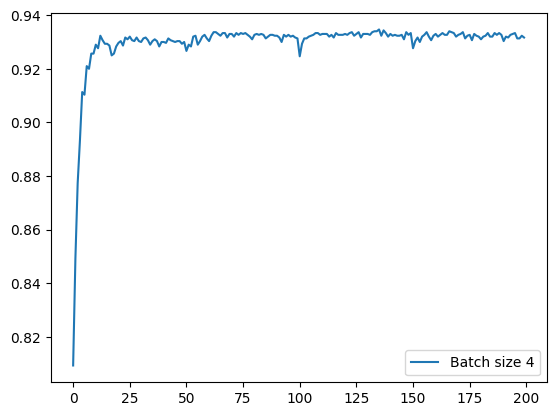

In [189]:
#plt.plot(np.arange(20), batch1, label=f'Batch size 1')
#plt.plot(np.arange(20), batch2, label=f'Batch size 2')
#plt.plot(np.arange(20), batch3, label=f'Batch size 3')
plt.plot(np.arange(200), atch3, label=f'Batch size 4')

plt.legend()


In [176]:
(np.mean(batch1),np.mean(batch2),np.mean(batch3),np.mean(batch4),)

(0.7423333333333334, 0.7038333333333332, 0.688, 0.6536166666666666)